In [1]:
"""
In order to run the code as is, you will need scipy, pandas and tqdm installed 
(although tqdm is only needed for the progress bar, and pandas is only for the autocorrelation function)
All of these can be installed (on linux) from the command interface using 'pip'
""" 

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from MHrank import MH_sample 
from eprank import exprop, pairwise_better_probs, pairwise_match_win_probs
import pandas
from cw2 import sorted_barplot

Coursework 2

We first need to load the data, stored in "tennis_data.mat". The data consists of an array, $W$ containing the names of each player, and an array, G, containing the results of all of the matches in the season. 

In [2]:
# set seed for reproducibility
np.random.seed(0)
# load data
data = sio.loadmat('tennis_data.mat')
# Array containing the names of each player
W = data['W']
# loop over array to format more nicely
for i, player in enumerate(W):
    W[i] = player[0]
# Array of size num_games x 2. The first entry in each row is the winner of game i, the second is the loser
games = data['G'] - 1
num_players = W.shape[0]
num_games = games.shape[0]

# MCMC sampling (this may take a minute)

In [3]:
# number of iterations -- the more the better!
num_its = 2000
# perform Metropolis MCMC sampling, skill samples is an num_players x num_samples array
skill_samples = MH_sample(games, num_players, num_its)

# discard the first half of the samples (burn-in period)
#skill_samples = skill_samples[:,num_iters//2:]

100%|██████████| 2000/2000 [00:38<00:00, 52.29it/s]


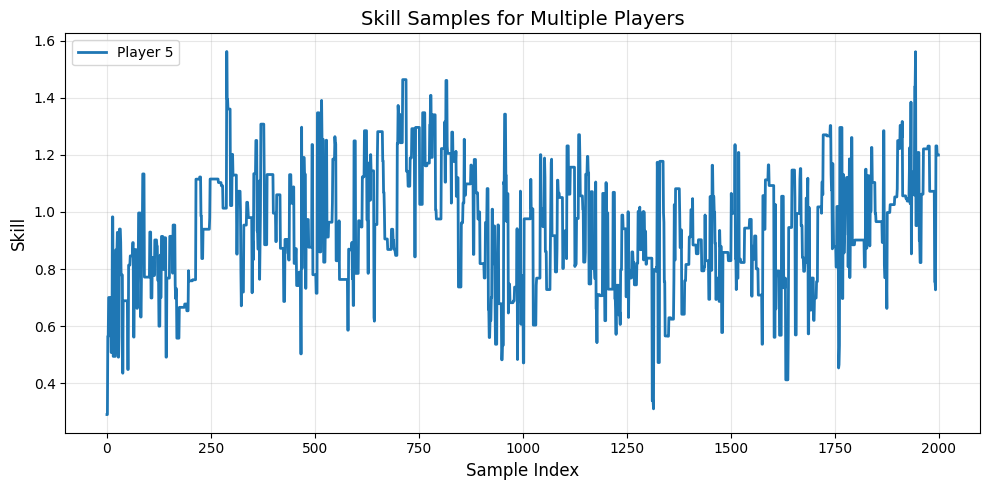

In [4]:
players_to_plot = [5]   # choose any player indices you want

plt.figure(figsize=(10, 5))

for p in players_to_plot:
    plt.plot(skill_samples[p, :2000], linewidth=2, label=f"Player {p}")

plt.title("Skill Samples for Multiple Players", fontsize=14)
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Skill", fontsize=12)

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

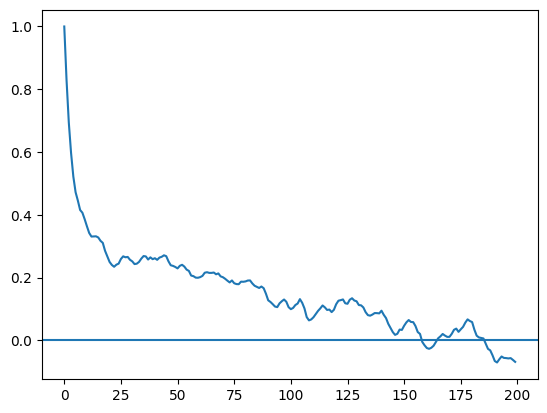

In [5]:
# plotting the autocorrelation function for player i
i = 5
autocor = np.zeros(200)
for t in range(200):
    autocor[t]=pandas.Series.autocorr(pandas.Series(skill_samples[i,:]),lag=t)
plt.plot(autocor)
plt.axhline(0)
plt.show()

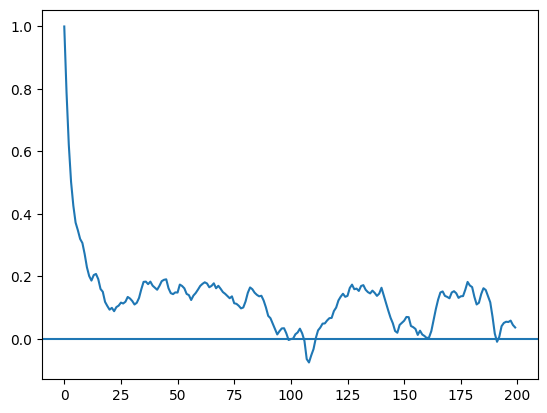

In [6]:
short_skill_samples = skill_samples[:,2000//2:]
i = 5
autocor = np.zeros(200)
for t in range(200):
    autocor[t]=pandas.Series.autocorr(pandas.Series(short_skill_samples[i,:]),lag=t)
plt.plot(autocor)
plt.axhline(0)
plt.show()

# Expectation propagation ranking

Iter 0: max_change=1.971e+00
Iter 1: max_change=3.690e-01
Iter 2: max_change=1.011e-01
Iter 3: max_change=2.084e-02
Iter 4: max_change=8.240e-03
Iter 5: max_change=5.803e-03
Iter 6: max_change=4.836e-03
Iter 7: max_change=4.178e-03
Iter 8: max_change=3.627e-03
Iter 9: max_change=3.148e-03
Iter 10: max_change=2.730e-03
Iter 11: max_change=2.366e-03
Iter 12: max_change=2.050e-03
Iter 13: max_change=1.775e-03
Iter 14: max_change=1.536e-03
Iter 15: max_change=1.329e-03
Iter 16: max_change=1.150e-03
Iter 17: max_change=9.947e-04
Converged at iteration 17


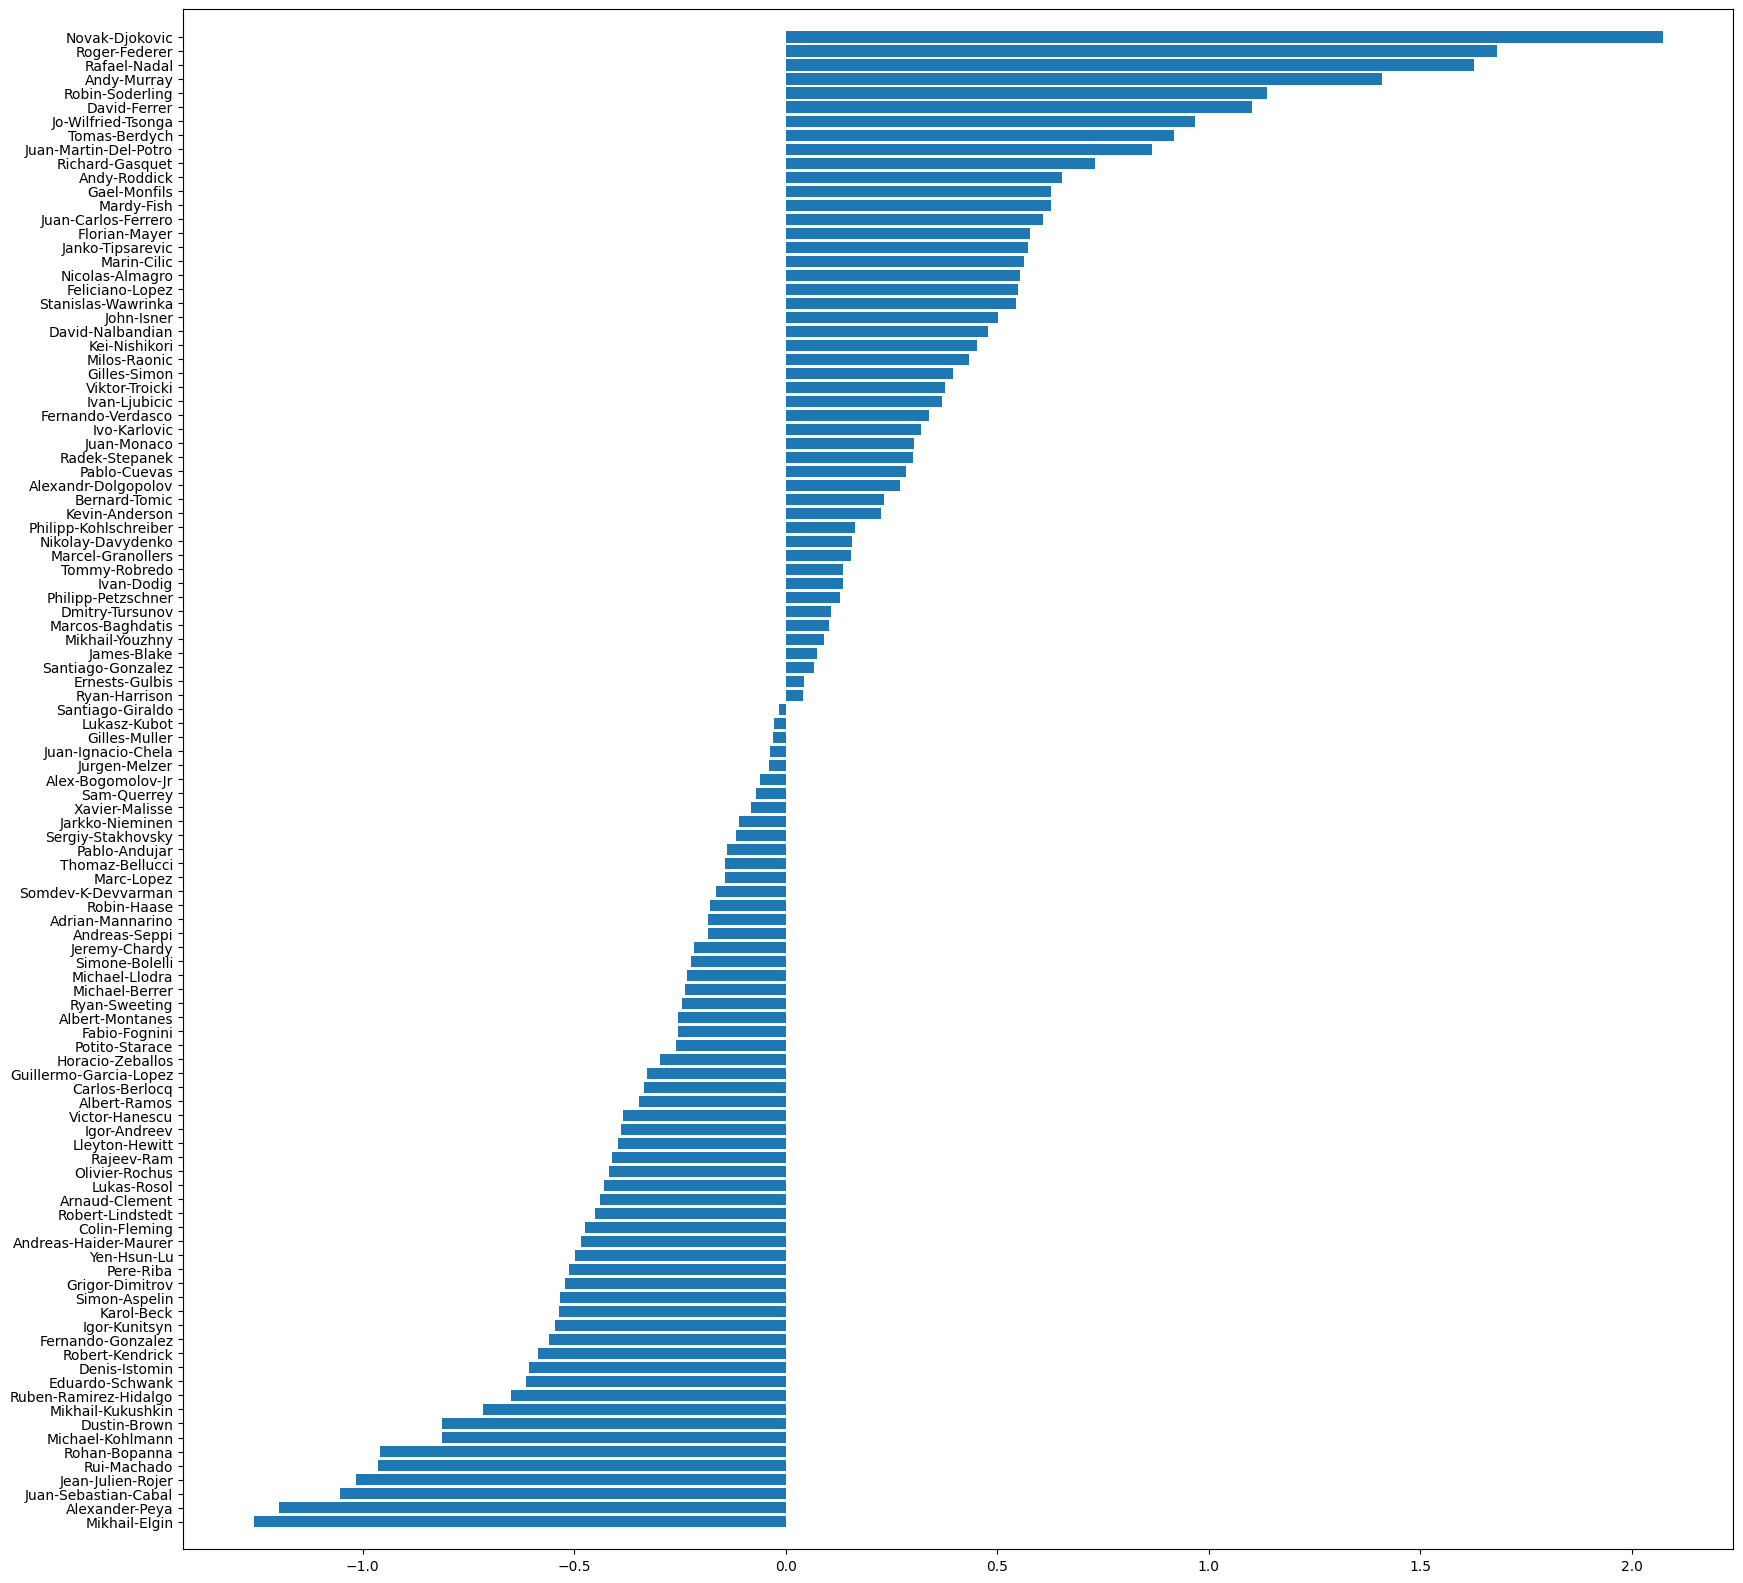

array([104,  96,  97, 106,  74, 101, 102,  88,  51,  85,  58,  66,  87,
        82,  67,  38, 103,  53,  84,  80,  91,  98, 105,  93,  94,  36,
        95,  70,  77,  55,  72,  50,   6,  56,  73,  43,  90,  18,  83,
        27,  49,  92,  48,  60,  59,  34, 100,  89,  21,  54,  30,  75,
        63,  81,  76,  78,  13,  86,   9,  71,  39,  99,  65,  52,  26,
        61,  64,  17,  69,  45,  40,  68,  62,  37,  32,  57,  19,   1,
        35,  16,  22,  79,  41,   8,  31,  12,  20,  46,  24,  42,  25,
        47,   7,  44,   3,  28,  14,  11,   2,  33,   5,  29,  23,  10,
         0,   4,  15], dtype=int64)

In [7]:
# run message passing algorithm, returns mean and variance for each player
ep_mean, ep_var = exprop(games, num_players, num_its = 25).T
sorted_barplot(ep_mean, W)

In [8]:
from scipy.special import ndtr as normcdf

In [9]:
idx = [15, 0, 4, 10]     # first 4 players

mean4 = ep_mean[idx]
var4  = ep_var[idx]
print(pairwise_better_probs(mean4, var4))
print(pairwise_match_win_probs(mean4, var4))

[[0.5        0.93690405 0.9113409  0.99007419]
 [0.06309595 0.5        0.42523264 0.78577451]
 [0.0886591  0.57476736 0.5        0.83799334]
 [0.00992581 0.21422549 0.16200666 0.5       ]]
[[0.5        0.66547854 0.64676334 0.73812822]
 [0.33452146 0.5        0.47964697 0.58313128]
 [0.35323666 0.52035303 0.5        0.60297773]
 [0.26187178 0.41686872 0.39702227 0.5       ]]


In [14]:
idx = [0, 4]

subset = short_skill_samples[idx]   # pick rows 15,0,4,10
subset_means = subset.mean(axis=1)
subset_vars  = subset.var(axis=1)

print(subset_means)
print(subset_vars)
diff_means = subset_means[0] - subset_means[1]
diff_std = subset_vars[0] + subset_vars[1]
P = normcdf(diff_means/ np.sqrt(diff_std))
print(P)

[1.56574309 1.63502629]
[0.03760496 0.05373201]
0.4093382677135805


In [15]:
x1 = short_skill_samples[0]
x2 = short_skill_samples[4]
cov = np.cov(x1, x2)
var_diff = cov[0, 0] + cov[1, 1] - 2 * cov[0, 1]
P = normcdf(diff_means/ np.sqrt(var_diff))
print(P)

0.3909345611223394


In [18]:
nadal_skill = short_skill_samples[0, :]
federer_skill = short_skill_samples[4, :]

count = 0
for i in range(1000):
    if nadal_skill[i] > federer_skill[i]:
        count += 1
P = count/1000
print(P)

0.367


In [13]:
def prob_i_beats_j_from_games(G, i, j):
    # G: shape (num_games, 2), each row [winner, loser]
    
    # games between i and j (either direction)
    mask_ij = ((G[:, 0] == i) & (G[:, 1] == j)) | \
              ((G[:, 0] == j) & (G[:, 1] == i))
    games_ij = G[mask_ij]
    
    n = len(games_ij)
    if n == 0:
        return np.nan  # or 0.5, or raise an error — up to you
    
    # count how many of those games i was the winner
    wins_i = np.sum(games_ij[:, 0] == i)
    return wins_i / n

prob_i_beats_j_from_games(games, 4,0)

0.25

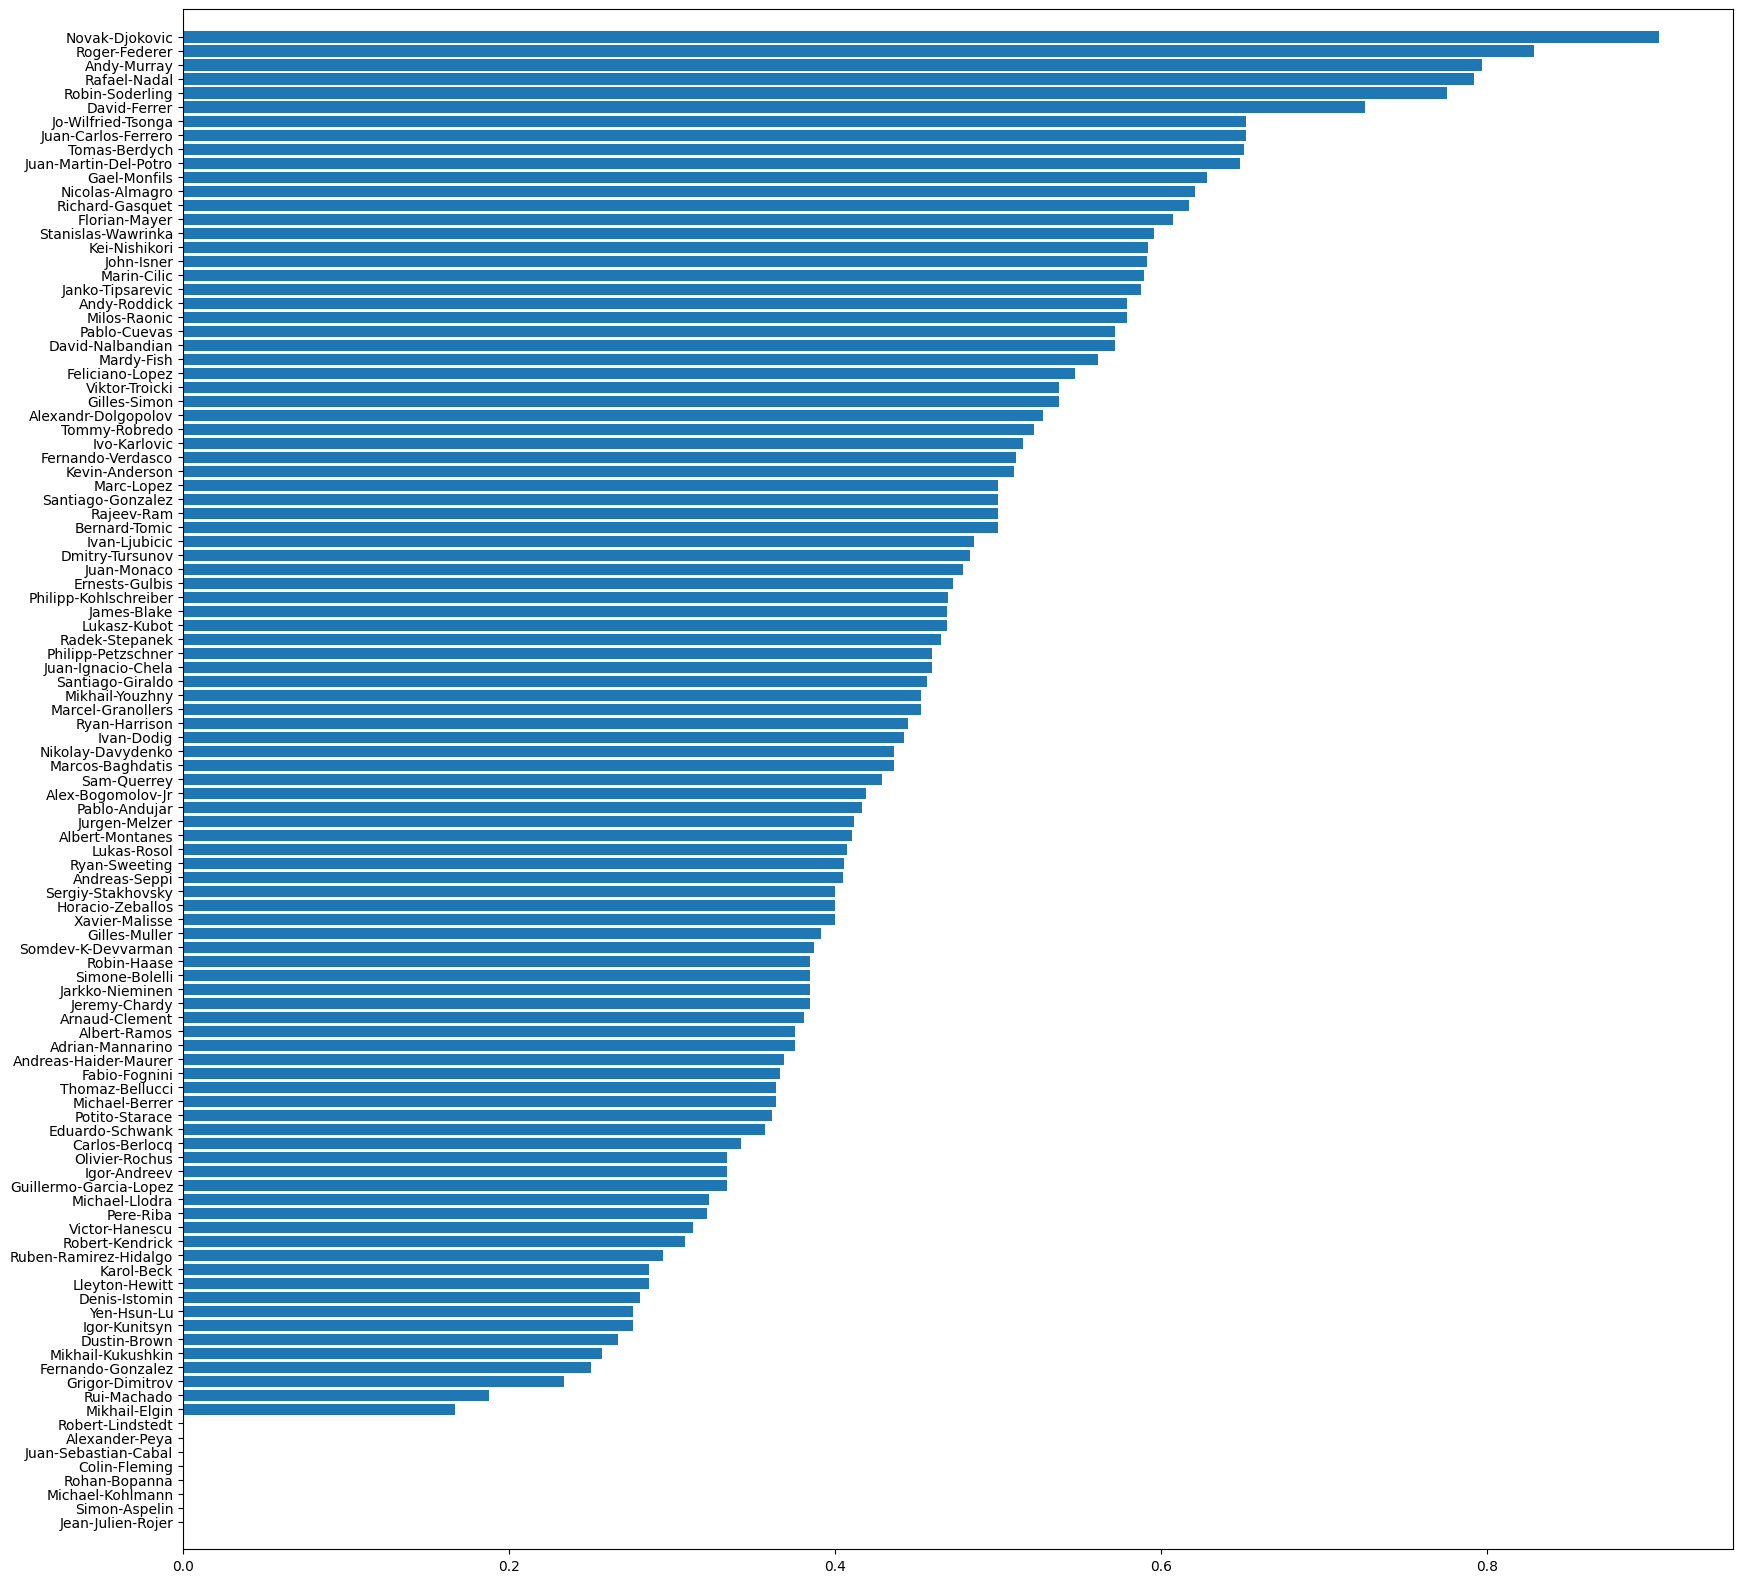

array([106, 103, 102, 101,  98,  97,  96, 105, 104,  74,  53,  82,  51,
        88,  67,  80,  66,  70,  38,  85,  87,  55,  84,  27,   6,  77,
        36,  50,  58,  73,  83,  89,  43,  91,  60,  72,  93,  92,  30,
        49,  59,  34,  13,  75,  56,  54,  48,  18,  94,  90,  76,  21,
        81,  63,  26,  40,  17,  71,  45,  52,   9,  78,  64,  19,  86,
        65,  68,  39,   1,  61,  22,  37,  95,  99, 100,  62,  16,  35,
        69,  32,  41,  79,  24,   3,  12,  57,   8,  14,  47,  25,  20,
        31,  46,   7,  11,  42,  28,   2,  33,  44,   5,  29,  23,   0,
        10,   4,  15], dtype=int64)

In [28]:
def compute_win_rates(games, num_players):
    wins = np.zeros(num_players, dtype=int)
    played = np.zeros(num_players, dtype=int)

    for w, l in games:
        wins[w] += 1
        played[w] += 1
        played[l] += 1

    win_rate = wins / played
    return win_rate
win_rate = compute_win_rates(games, num_players)
sorted_barplot(win_rate, W)

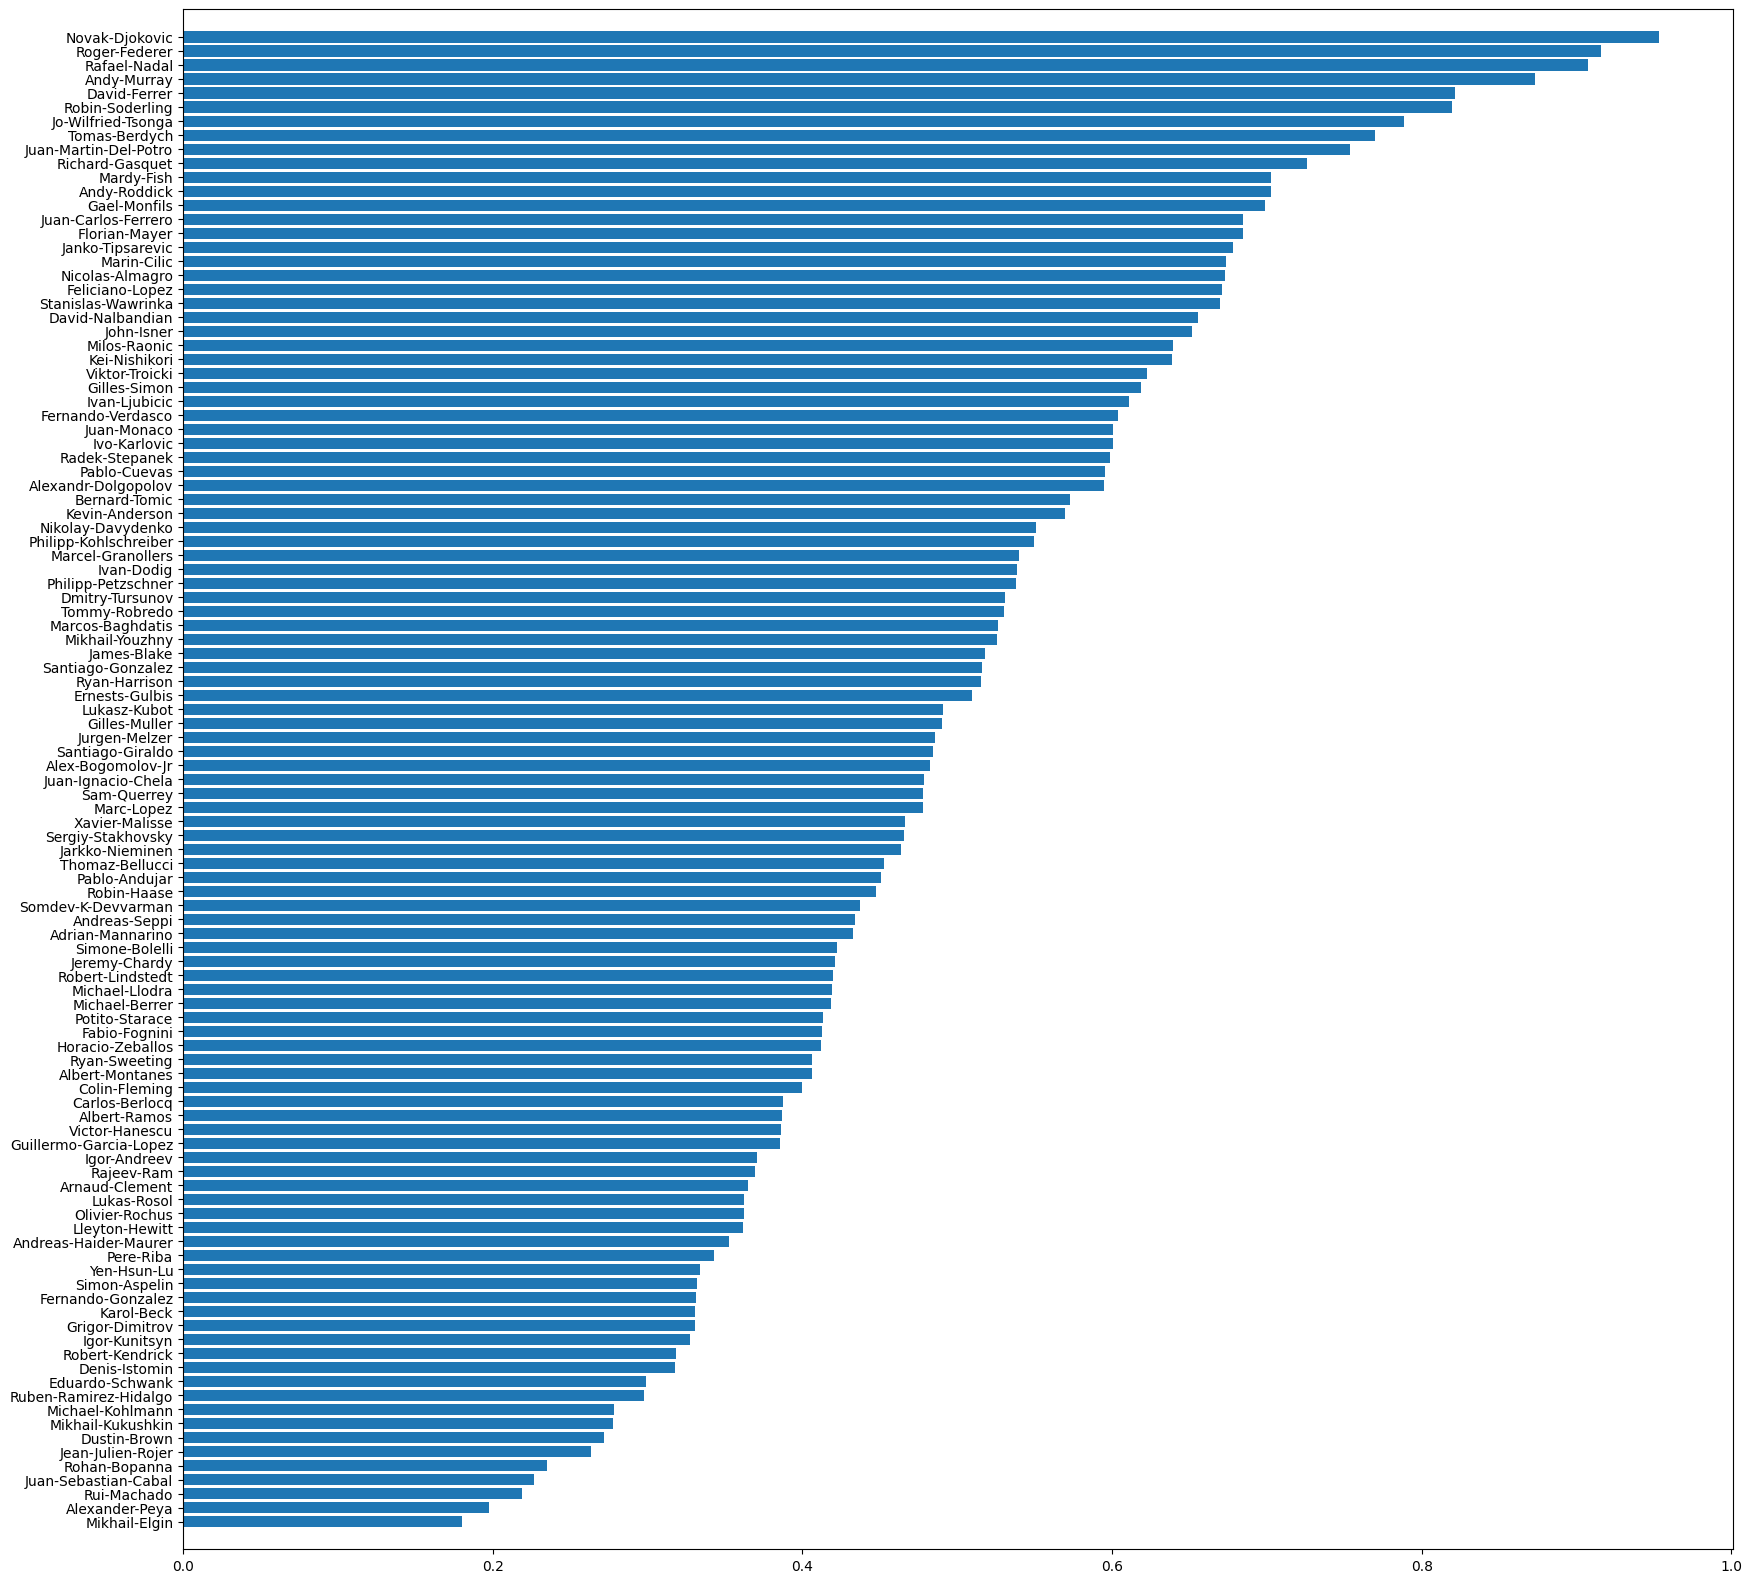

array([104,  96,  74,  97, 101, 106,  88,  51, 102,  85,  58,  66,  87,
        67,  53,  38,  82, 103,  80,  84,  91,  70,  36,  94,  93,  95,
        77,   6,  55,  72,  50,  98,  90,  18,  56,  43,  73,  83,  27,
       105,  92,  49,  60,  48,  34,  59,  21,  89,  30,  54,  75, 100,
        63,  78,  81,   9,  76,  13,  86,  39,  71,  99,  65,  52,  26,
        69,  61,  64,  17,  45,  68,  40,  62,  37,  32,  57,  19,  35,
         1,  16,  22,  41,  79,  31,   8,  20,  12,  46,  24,  42,  25,
        47,   7,  44,  28,  14,   3,  11,   2,  33,   5,  23,  29,  10,
         0,   4,  15], dtype=int64)

In [45]:
num_players, num_samples = short_skill_samples.shape

all_preds = []  

for i in range(num_players):
    pred = 0
    for j in range(num_players):
        Z = (short_skill_samples[i,:] - short_skill_samples[j,:])
        pred += normcdf(Z).mean()
    all_preds.append(pred/107)
sorted_barplot(np.array(all_preds), W)

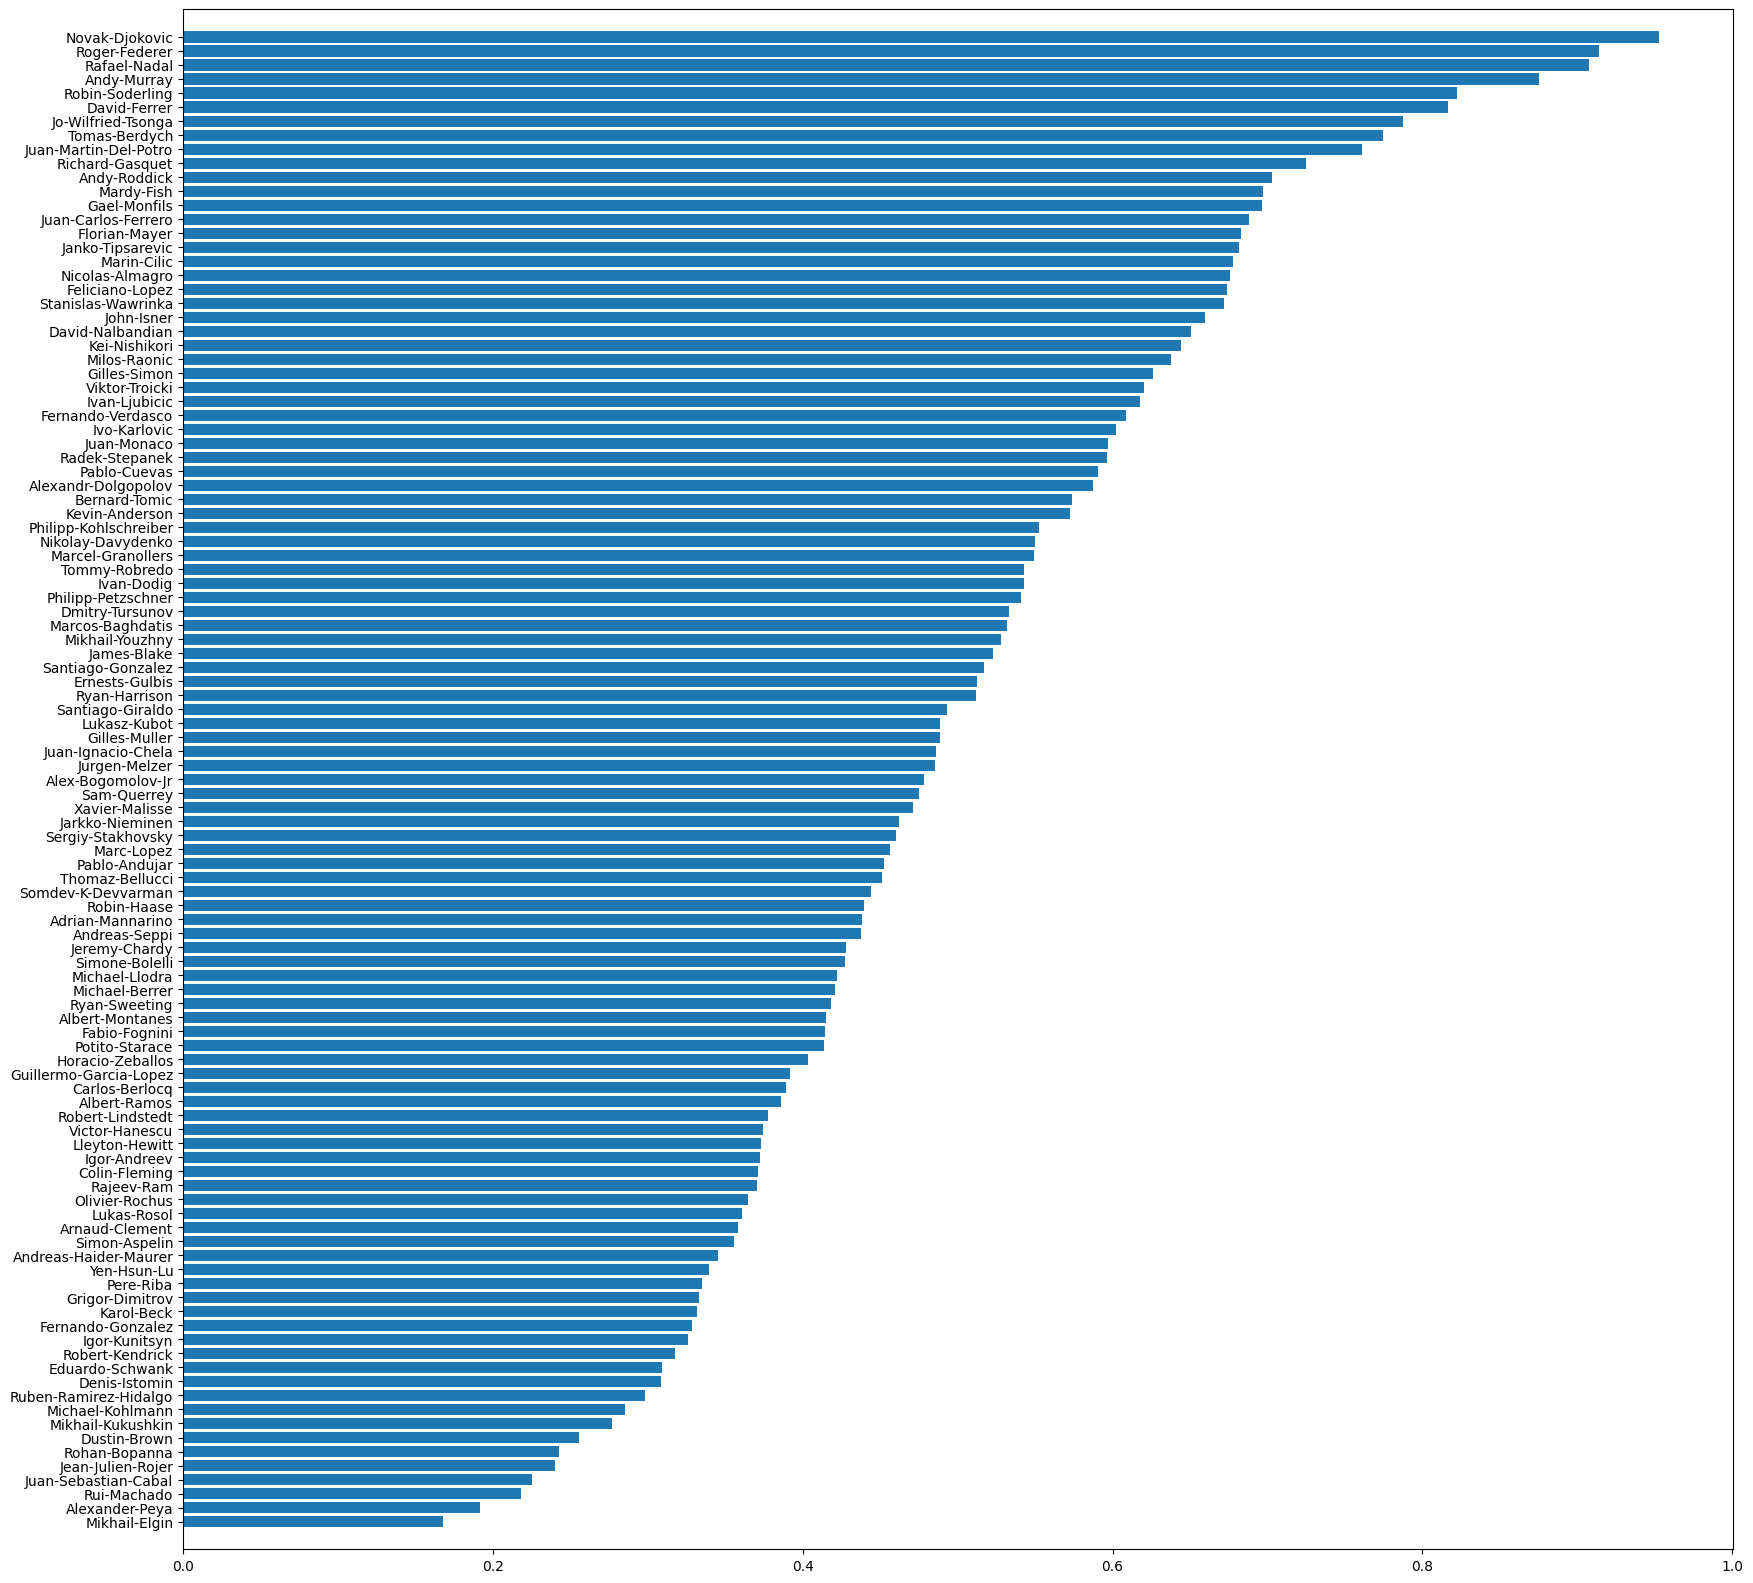

array([104,  96,  74,  97, 106, 101,  88,  51, 102,  85,  66,  58,  87,
        67,  82,  38,  53,  84,  80,  91, 103,  93,  94,  36,  95,  98,
        77,  70,  55, 105,  72,  50,   6,  56,  73,  43,  90,  18,  83,
        27,  49,  92,  48,  60,  59,  34,  89,  21, 100,  54,  30,  75,
        63,  81,  76,  78,  13,  86,   9,  71,  39,  99,  65,  52,  26,
        61,  64,  17,  69,  45,  40,  68,  62,  37,  32,  57,  19,   1,
        35,  16,  22,  79,  41,   8,  31,  12,  20,  46,  24,  42,  25,
        47,   7,  44,  28,   3,  14,  11,   2,  33,   5,  29,  23,  10,
         0,   4,  15], dtype=int64)

In [47]:
num_players, num_samples = short_skill_samples.shape

all_preds = []  

for i in range(num_players):
    pred = 0
    for j in range(num_players):
        Z = (ep_mean[i]-ep_mean[j])/np.sqrt((ep_var[i] + ep_var[j]+1))
        pred += normcdf(Z)
    all_preds.append(pred/107)
sorted_barplot(np.array(all_preds), W)